In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,BaggingRegressor,AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from tqdm.notebook import tqdm

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import pandas_datareader as web
from datetime import datetime as dt

/usr/local/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [5]:
import requests
from bs4 import BeautifulSoup

# Scrape Dow Jones Tickers

In [99]:
response = requests.get('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')                                                                                                                                                      
soup = BeautifulSoup(response.text, 'lxml')                                                                                                                                                                                              
dji_tickers = ['^DJI']                                                                                                                                                                                                                             

table = soup.find('table',{'id':'constituents'})                                                                                                                                                                                           

for row in table.findAll('tr')[1:]:
    row_text = row.findAll('td')

    ticker = row_text[2].text.replace("NYSE:\xa0", "").replace("\n","")
    
    dji_tickers.append(ticker)
#dji_tickers

# Scrape S&P Tickers

In [6]:
response = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')                                                                                                                                                      
soup = BeautifulSoup(response.text, 'lxml')                                                                                                                                                                                              
sp_tickers = ['^GSPC']                                                                                                                                                                                                                            

table = soup.find('table',{'id':'constituents'})                                                                                                                                                                                           

for row in table.findAll('tr')[1:]:
    row_text = row.findAll('td')
    ticker = row_text[0].text.replace("\n", "")                                                                                                                                                                                              
    sp_tickers.append(ticker)       

# Following Advice From Towards Data Science

In [7]:
df = web.DataReader('MSFT','yahoo',dt(2010,4,14),dt.today())

# Feature Engineering

In [9]:
df['Close'] = df['Adj Close']
del df['Adj Close']

In [11]:
for sma_period in [5,10,20,50,100,200]:
    indicator_name = "SMA_%d" % (sma_period)
    df[indicator_name] = df['Close'].rolling(sma_period).mean()

In [13]:
df['BollingerBand_Up_20_2'] = df['Close'].rolling(20).mean() + 2*df['Close'].rolling(20).std()
df['BollingerBand_Down_20_2'] = df['Close'].rolling(20).mean() - 2*df['Close'].rolling(20).std()
df['BollingerBand_Up_20_1'] = df['Close'].rolling(20).mean() + df['Close'].rolling(20).std()
df['BollingerBand_Down_20_1'] = df['Close'].rolling(20).mean() - df['Close'].rolling(20).std()
df['BollingerBand_Up_10_1'] = df['Close'].rolling(10).mean() + df['Close'].rolling(10).std()
df['BollingerBand_Down_10_1'] = df['Close'].rolling(10).mean() - df['Close'].rolling(10).std()
df['BollingerBand_Up_10_2'] = df['Close'].rolling(10).mean() + 2*df['Close'].rolling(10).std()
df['BollingerBand_Down_10_2'] = df['Close'].rolling(10).mean() - 2*df['Close'].rolling(10).std()

In [14]:
for channel_period in [5,10,20,50,100,200]:
    up_name = "Donchian_Channel_Up_%d" % (channel_period)
    down_name = "Donchian_Channel_Down_%d" % (channel_period)
    
    df[up_name] = df['High'].rolling(channel_period).max()
    df[down_name] = df['Low'].rolling(channel_period).min()

In [26]:
newdata = df['Close'].to_frame()
for lag in [1,2,3,4,5,6,7,8,9,10]:
    shift = lag
    shifted = df.shift(shift)
    shifted.columns = [str.format("%s_shifted_by_%d" % (column ,shift)) for column in shifted.columns]
    newdata = pd.concat((newdata,shifted),axis=1)

In [27]:
newdata.tail()

,Close,High_shifted_by_1,Low_shifted_by_1,Open_shifted_by_1,Close_shifted_by_1,Volume_shifted_by_1,SMA_5_shifted_by_1,SMA_10_shifted_by_1,SMA_20_shifted_by_1,SMA_50_shifted_by_1,...,Donchian_Channel_Up_10_shifted_by_10,Donchian_Channel_Down_10_shifted_by_10,Donchian_Channel_Up_20_shifted_by_10,Donchian_Channel_Down_20_shifted_by_10,Donchian_Channel_Up_50_shifted_by_10,Donchian_Channel_Down_50_shifted_by_10,Donchian_Channel_Up_100_shifted_by_10,Donchian_Channel_Down_100_shifted_by_10,Donchian_Channel_Up_200_shifted_by_10,Donchian_Channel_Down_200_shifted_by_10
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-07,163.490005,166.500000,157.580002,160.320007,165.270004,67111700.0,156.836002,154.548000,149.817500,164.186871,...,161.910004,132.520004,175.0,132.520004,190.699997,132.520004,190.699997,132.520004,190.699997,130.710007
2020-04-08,165.130005,170.000000,163.259995,169.589996,163.490005,62769000.0,157.992001,156.063000,149.946001,164.219912,...,161.910004,132.520004,175.0,132.520004,190.699997,132.520004,190.699997,132.520004,190.699997,130.710007
2020-04-09,165.139999,166.669998,163.500000,165.669998,165.130005,48318200.0,160.596002,157.884001,150.521001,164.222326,...,161.910004,132.520004,175.0,132.520004,190.699997,132.520004,190.699997,132.520004,190.699997,130.710007
2020-04-13,165.509995,167.369995,163.330002,166.360001,165.139999,51431800.0,162.572003,158.787001,151.825001,164.173481,...,156.660004,132.520004,175.0,132.520004,190.699997,132.520004,190.699997,132.520004,190.699997,130.779999
2020-04-14,173.699997,165.570007,162.300003,164.350006,165.509995,41814200.0,164.908002,160.368001,152.159000,164.037494,...,160.600006,132.520004,175.0,132.520004,190.699997,132.520004,190.699997,132.520004,190.699997,130.779999


In [28]:
forward_lag = 5
newdata['target'] = newdata['Close'].shift(-forward_lag)
newdata = newdata.drop('Close',axis=1)
newdata = newdata.dropna()

# Training/Test Data Split

## Random Split (not a good choice)

In [33]:
# X = newdata.drop("target",axis=1)
# y = newdata['target']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Time Series Split

In [115]:
X = newdata.drop("target",axis=1)
y = newdata['target']

train_size = int(X.shape[0]*0.7)

X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

## 50 Most Important Features

In [116]:
correlations = np.abs(X_train.corrwith(y_train))
features =  list(correlations.sort_values(ascending=False)[0:50].index)
X_train = X_train[features]
X_test = X_test[features]

# Metrics Tracking

In [117]:
mean_absolute_errors = {}

# Models

## Linear Regression

In [118]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [119]:
y_pred = lr.predict(X_test)

In [120]:
mar = metrics.mean_absolute_error(y_test,y_pred)
mean_absolute_errors['Linear Regression'] = mar
mar

2.971627894753766

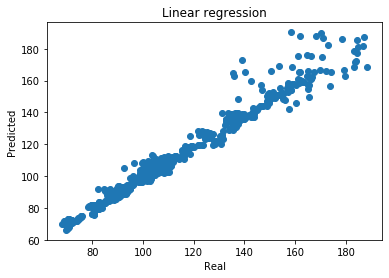

In [121]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Linear regression")
plt.show()

# Random Forest

In [123]:
rf = RandomizedSearchCV(
        RandomForestRegressor(),
        param_distributions =  {
            'n_estimators':np.arange(10,500,5),
            'max_features':np.arange(1,10,1)
        },
        cv=5, 
        n_iter = 20,
        iid=False,
        random_state=0,
        refit=True,
        scoring="neg_mean_absolute_error",
        verbose=True,
        n_jobs=-2
        )

In [124]:
rf.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:   13.2s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [125]:
rf.best_params_

{'n_estimators': 310, 'max_features': 1}

In [126]:
y_pred = rf.predict(X_test)

In [127]:
mar = metrics.mean_absolute_error(y_test,y_pred)
mean_absolute_errors['Random Forest'] = mar
mar

45.50888969717288

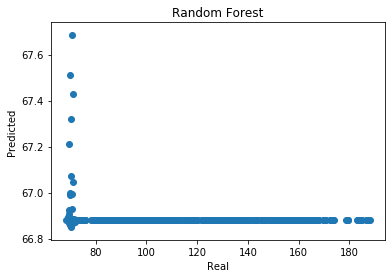

In [128]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Random Forest")
plt.show()

In [129]:
gb = RandomizedSearchCV(
    GradientBoostingRegressor(),
    param_distributions =  {
        'n_estimators':np.arange(10,500,5),
        'max_features':np.arange(1,10,1)
    },
    cv=5, 
    n_iter = 20,
    iid=False,
    random_state=0,
    refit=True,
    scoring="neg_mean_absolute_error",
    verbose=True,
    n_jobs=-2)

gb.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    2.4s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [130]:
gb.best_params_

{'n_estimators': 85, 'max_features': 8}

In [131]:
y_pred = gb.predict(X_test)

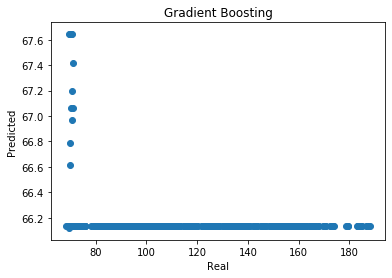

In [132]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Gradient Boosting")
plt.show()

In [133]:
mar = metrics.mean_absolute_error(y_test,y_pred)
mean_absolute_errors['Gradient Boosting'] = mar
mar

46.24066944571564

# K Nearest Neighbors

In [134]:
knn = GridSearchCV(
    KNeighborsRegressor(),
    param_grid =  {
        'n_neighbors':np.arange(1,20,1),
        'weights':['distance','uniform']
    },
    cv=5, 
    iid=False,
    refit=True,
    scoring="neg_mean_absolute_error",
    verbose=True,
    n_jobs=-2)

knn.fit(X_train,y_train)

Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 190 out of 190 | elapsed:    0.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid=False, n_jobs=-2,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'weights': ['distance', 'uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=True)

In [135]:
knn.best_params_

{'n_neighbors': 19, 'weights': 'uniform'}

In [136]:
y_pred = knn.predict(X_test)

In [137]:
mar = metrics.mean_absolute_error(y_test,y_pred)
mean_absolute_errors['KNN'] = mar
mar

45.68872109596802

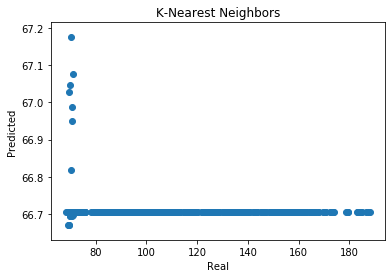

In [138]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("K-Nearest Neighbors")
plt.show()

# Neural Net

In [139]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

nn = RandomizedSearchCV(
    MLPRegressor(
        max_iter=5000,
        learning_rate = 'adaptive',
        solver='sgd'
    ),
    param_distributions =  {
        'hidden_layer_sizes':[(x,) for x in np.arange(1,50,1)],
         'activation':['logistic','relu']
    },
    cv=5, 
    n_iter = 20,
    iid=False,
    random_state=0,
    refit=True,
    scoring="neg_mean_absolute_error",
    verbose=True,
    n_jobs=-2
    )

nn.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:   18.2s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                          batch_size='auto', beta_1=0.9,
                                          beta_2=0.999, early_stopping=False,
                                          epsilon=1e-08,
                                          hidden_layer_sizes=(100,),
                                          learning_rate='adaptive',
                                          learning_rate_init=0.001,
                                          max_iter=5000, momentum=0.9,
                                          n_iter_no_change=10,
                                          nesterovs_momentum=True, power_t=0.5,
                                          rand...
                   param_distributions={'activation': ['logistic', 'relu'],
                                        'hidden_layer_sizes': [(1,), (2,), (3,),
                                 

In [140]:
nn.best_params_

{'hidden_layer_sizes': (20,), 'activation': 'relu'}

In [141]:
X_test_scaled = scaler.transform(X_test)
y_pred = nn.predict(X_test_scaled)
mar = metrics.mean_absolute_error(y_test,y_pred)
mean_absolute_errors['Neural Net'] = mar
mar

3.1524068425604566

In [142]:
mean_absolute_errors

{'Linear Regression': 2.971627894753766,
 'Random Forest': 45.50888969717288,
 'Gradient Boosting': 46.24066944571564,
 'KNN': 45.68872109596802,
 'Neural Net': 3.1524068425604566}

## Linear Regression w/ Bagging

In [145]:
lr_bag = RandomizedSearchCV(
    BaggingRegressor(LinearRegression()),
    param_distributions =  {
        'n_estimators':np.arange(10,500,5),
        'max_features':np.arange(1,10,1)
    },
    cv=5, 
    n_iter = 20,
    iid=False,
    random_state=0,
    refit=True,
          
    scoring="neg_mean_absolute_error",
    verbose=True,
    n_jobs=-2
    )

lr_bag.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    5.6s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=BaggingRegressor(base_estimator=LinearRegression(copy_X=True,
                                                                              fit_intercept=True,
                                                                              n_jobs=None,
                                                                              normalize=False),
                                              bootstrap=True,
                                              bootstrap_features=False,
                                              max_features=1.0, max_samples=1.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
                   iid=False, n_...
       205, 210, 215, 220, 225, 230

In [146]:
lr_bag.best_params_

{'n_estimators': 365, 'max_features': 9}

In [148]:
y_pred = lr_bag.predict(X_test)
mar = metrics.mean_absolute_error(y_test,y_pred)
mean_absolute_errors['Linear Regression w/ Bagging'] = mar
mar

2.9975646668112215

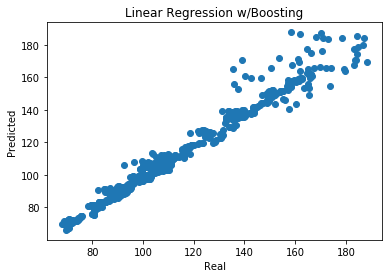

In [149]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Linear Regression w/Boosting")
plt.show()

## Linear Regression w/ Boosting

In [152]:
lr_boost = GridSearchCV(
    AdaBoostRegressor(LinearRegression()),
    param_grid =  {
        'n_estimators':np.arange(20,500,5)
    },
    cv=5, 
    iid=False,
    refit=True,
    scoring="neg_mean_absolute_error",
    verbose=True,
    n_jobs=-2
    )

lr_boost.fit(X_train,y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done 334 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-2)]: Done 459 out of 480 | elapsed:    4.0s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done 480 out of 480 | elapsed:    4.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostRegressor(base_estimator=LinearRegression(copy_X=True,
                                                                         fit_intercept=True,
                                                                         n_jobs=None,
                                                                         normalize=False),
                                         learning_rate=1.0, loss='linear',
                                         n_estimators=50, random_state=None),
             iid=False, n_jobs=-2,
             param_grid={'n_estimators': array([ 20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,
        85,  90,  95, 100, 105, 110...
       150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210,
       215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275,
       280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340,
       345, 350, 355, 360, 365, 370,

In [153]:
lr_boost.best_params_

{'n_estimators': 160}

In [155]:
y_pred = lr_boost.predict(X_test)
mar = metrics.mean_absolute_error(y_test,y_pred)
mean_absolute_errors['Linear Regression w/ Boosting'] = mar
mar

3.370315698474024

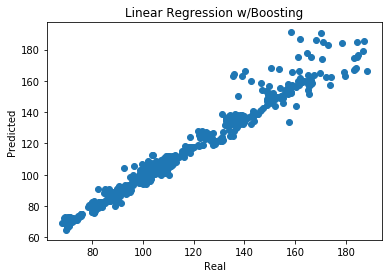

In [156]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Linear Regression w/Boosting")
plt.show()

In [157]:
mean_absolute_errors

{'Linear Regression': 2.971627894753766,
 'Random Forest': 45.50888969717288,
 'Gradient Boosting': 46.24066944571564,
 'KNN': 45.68872109596802,
 'Neural Net': 3.1524068425604566,
 'Linear Regression w/ Bagging': 2.9975646668112215,
 'Linear Regression w/ Boosting': 3.370315698474024}

# Evaluate Models on S&P 500 Companies

In [7]:
def get_new_models():
    lr = LinearRegression()

    rf = RandomizedSearchCV(
            RandomForestRegressor(),
            param_distributions =  {
                'n_estimators':np.arange(10,500,5),
                'max_features':np.arange(1,10,1)
            },
            cv=5, 
            n_iter = 20,
            iid=False,
            random_state=0,
            refit=True,
            scoring="neg_mean_absolute_error",
            verbose=True,
            n_jobs=-2
            )

    knn = GridSearchCV(
        KNeighborsRegressor(),
        param_grid =  {
            'n_neighbors':np.arange(1,20,1),
            'weights':['distance','uniform']
        },
        cv=5, 
        iid=False,
        refit=True,
        scoring="neg_mean_absolute_error",
        verbose=True,
        n_jobs=-2)

    gb = RandomizedSearchCV(
        GradientBoostingRegressor(),
        param_distributions =  {
            'n_estimators':np.arange(10,500,5),
            'max_features':np.arange(1,10,1)
        },
        cv=5, 
        n_iter = 20,
        iid=False,
        random_state=0,
        refit=True,
        scoring="neg_mean_absolute_error",
        verbose=True,
        n_jobs=-2)

    nn = RandomizedSearchCV(
        MLPRegressor(
            max_iter=5000,
            learning_rate = 'adaptive',
            solver='sgd'
        ),
        param_distributions =  {
            'hidden_layer_sizes':[(x,) for x in np.arange(1,50,1)],
             'activation':['logistic','relu']
        },
        cv=5, 
        n_iter = 20,
        iid=False,
        random_state=0,
        refit=True,
        scoring="neg_mean_absolute_error",
        verbose=True,
        n_jobs=-2
        )

    lr_bag = RandomizedSearchCV(
        BaggingRegressor(LinearRegression()),
        param_distributions =  {
            'n_estimators':np.arange(10,500,5),
            'max_features':np.arange(1,10,1)
        },
        cv=5, 
        n_iter = 20,
        iid=False,
        random_state=0,
        refit=True,

        scoring="neg_mean_absolute_error",
        verbose=True,
        n_jobs=-2
        )

    lr_boost = GridSearchCV(
        AdaBoostRegressor(LinearRegression()),
        param_grid =  {
            'n_estimators':np.arange(20,500,5)
        },
        cv=5, 
        iid=False,
        refit=True,
        scoring="neg_mean_absolute_error",
        verbose=True,
        n_jobs=-2
        )
    return [lr,rf,knn,gb,nn,lr_bag,lr_boost]


In [8]:
def gen_df(ticker,start=dt(2000,1,1),end=dt.today()):
    df = web.DataReader(ticker,'yahoo',start,end)

    df['Close'] = df['Adj Close']
    del df['Adj Close']

    for sma_period in [5,10,20,50,100,200]:
        indicator_name = "SMA_%d" % (sma_period)
        df[indicator_name] = df['Close'].rolling(sma_period).mean()

    df['BollingerBand_Up_20_2'] = df['Close'].rolling(20).mean() + 2*df['Close'].rolling(20).std()
    df['BollingerBand_Down_20_2'] = df['Close'].rolling(20).mean() - 2*df['Close'].rolling(20).std()
    df['BollingerBand_Up_20_1'] = df['Close'].rolling(20).mean() + df['Close'].rolling(20).std()
    df['BollingerBand_Down_20_1'] = df['Close'].rolling(20).mean() - df['Close'].rolling(20).std()
    df['BollingerBand_Up_10_1'] = df['Close'].rolling(10).mean() + df['Close'].rolling(10).std()
    df['BollingerBand_Down_10_1'] = df['Close'].rolling(10).mean() - df['Close'].rolling(10).std()
    df['BollingerBand_Up_10_2'] = df['Close'].rolling(10).mean() + 2*df['Close'].rolling(10).std()
    df['BollingerBand_Down_10_2'] = df['Close'].rolling(10).mean() - 2*df['Close'].rolling(10).std()

    for channel_period in [5,10,20,50,100,200]:
        up_name = "Donchian_Channel_Up_%d" % (channel_period)
        down_name = "Donchian_Channel_Down_%d" % (channel_period)

        df[up_name] = df['High'].rolling(channel_period).max()
        df[down_name] = df['Low'].rolling(channel_period).min()

    newdata = df['Close'].to_frame()

    for lag in [1,2,3,4,5,6,7,8,9,10]:
        shift = lag
        shifted = df.shift(shift)
        shifted.columns = [str.format("%s_shifted_by_%d" % (column ,shift)) for column in shifted.columns]
        newdata = pd.concat((newdata,shifted),axis=1)

    forward_lag = 5

    newdata['target'] = newdata['Close'].shift(-forward_lag)

    newdata = newdata.drop('Close',axis=1)
    newdata = newdata.dropna()
    return newdata

In [9]:
def gen_data(df):
    X = df.drop("target",axis=1)
    y = df['target']

    train_size = int(X.shape[0]*0.7)


    X_train = X[0:train_size]
    y_train = y[0:train_size]


    X_test = X[train_size:]
    y_test = y[train_size:]
    
    correlations = np.abs(X_train.corrwith(y_train))
    features =  list(correlations.sort_values(ascending=False)[0:50].index)
    X_train = X_train[features]
    X_test = X_test[features]
    
    return X_train,X_test,y_train,y_test

In [11]:
model_names = ['Linear Regression',
               'Random Forest',                              
               'KNN',
               'Gradient Boosting',
               'Neural Net',
               'Linear Regression w/ Bagging',
               'Linear Regression w/ Boosting']

In [ ]:
mean_absolute_errors = {}
ticker_models = {}
for ticker in tqdm(sp_tickers,desc='Tickers'):     
    try:
        errors = {}
        models_dict = {}
        df = gen_df(ticker)
        X_train,X_test,y_train,y_test = gen_data(df)
        models = get_new_models()
        for i,model in tqdm(enumerate(models),desc='Models'):
            if model_names[i] == 'Neural Net':
                scaler = MinMaxScaler()
                scaler.fit(X_train)
                X_train_real = scaler.transform(X_train)
                X_test_real = scaler.transform(X_test)
            else:
                X_train_real = X_train
                X_test_real = X_test
            model.fit(X_train_real,y_train)
            y_pred = model.predict(X_test_real)
            mar = metrics.mean_absolute_error(y_test,y_pred)
            errors[model_names[i]] = mar       
            models_dict[model_names[i]] = model

        ticker_models[ticker] = models_dict
        mean_absolute_errors[ticker] = errors
    except:
        sp_tickers.remove(ticker)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:   25.5s finished


Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 190 out of 190 | elapsed:    0.8s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done  79 out of 100 | elapsed:    4.1s remaining:    1.1s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    4.4s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.


In [ ]:
print(mean_absolute_errors)
print(ticker_models)